In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sampleSubmission.csv', 'test.csv']


In [2]:
#datetime은 날짜형식으로 바꿔서 데이터 불러오기
train = pd.read_csv("../input/train.csv", parse_dates = ["datetime"])
test = pd.read_csv("../input/test.csv", parse_dates = ["datetime"])

In [3]:
#month를 뺸 이유: season으로 알 수 있음
#day를 뺸이유: training set과 test set의 기준의 차이가 있기 때문
#For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month.

train["year"] = train["datetime"].dt.year
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek

test["year"] = test["datetime"].dt.year
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek

# 앙상블 방법론
여러가지 모델의 예측값을 합치는 것

앙상블 방법 사용할떄 전제조건
1. 어느정도의 모델의 성능이 뒷받침되는 모델을 사용해야한다.
2. 최대한 모델 학습 방식이 서로서로 다를 수록 좋다. 다양성을 확보해야한다. (모델을 다르게, 하이퍼파라미터를 다르게, 넣어주는 데이터를 다르게)

성능이 올라가는 이유
1. 각각 모델은 학습하는 방식이 다를 것이다. 서로 장단점을 메꿔주는 시너지 효과
2. 다양한 시야로 바라보면서 학습하기때문에 overfitting 문제가 더 줄어든다.

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,4,5


In [5]:
# casual, registered 각각 모델로 돌려서 학습 예측하면 좋은 점
# 1. casual 비정기적으로 빌리는 사람의 패턴과 2. registered 만의 정기적으로 빌리는 사람의 패턴을 더해서 하면 훨씬 정보를 많이 파악하기 때문에 결과가 좋다.

In [6]:
# log1p에서 1p의 뜻은 plus 1 : 0값이 들어오면 -무한대 되서
y_casual = np.log1p(train["casual"])
y_registered = np.log1p(train["registered"])

In [7]:
train.drop(["datetime", "windspeed", "casual", "registered", "count"], 1, inplace=True)
test.drop(["datetime", "windspeed", ], 1, inplace=True)

KeyError: 'count'

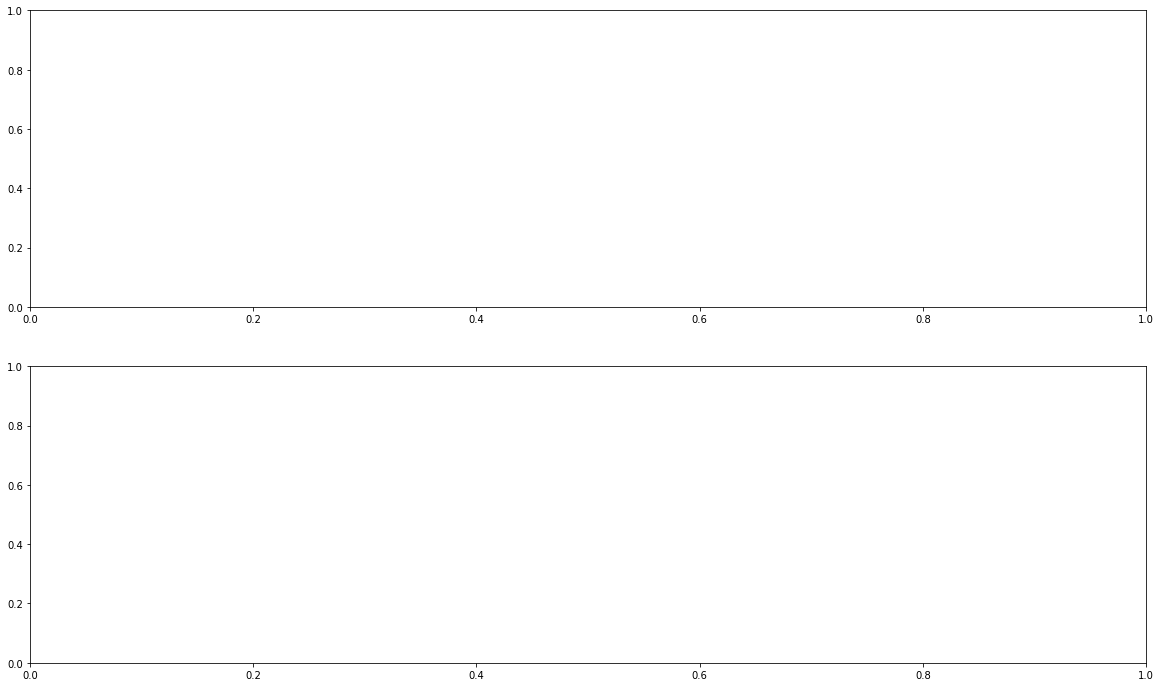

In [8]:
#train = pd.read_csv("../input/train.csv", parse_dates = ["datetime"])
import seaborn as sns #그래프를 그릴때
import matplotlib.pylab as plt #밑그림을 그릴때
fig,axes = plt.subplots(2,1, figsize=(20,12)) #subplot(행, 열, figsize(도면 크기))
sns.distplot(train["count"],ax=axes[0])
sns.distplot(np.log(train["count"]),ax=axes[1])  

# 회귀문제 풀때 종속에 log 취하면 
#1.모델 학습 시간이 빨라짐 (이유: 어떤식으로 decision boundry를 나눠줄것이냐를 쉽게 선택. information gain이 높아지는 방향으로 학습, 엔트로피가 낮아지는 방향으로 학습) 
#2. 성능이 올라감 (이유: log 없이 하면 이상치 극단치 문제, 로그 없이 하면 극단치 관련 unseen 값이 들어왔을때 틀려버리면 엄청 큰 패널티를 줘버림, outlier을 제거하지않았는데도 outlier을 제거한것 같은 효과를 불러일으킴))

In [9]:
# #LightGBM 모델 

# #1.모델을 가져온다. 회귀문제이므로 regrssor로 불러옴
# from lightgbm import LGBMRegressor

# #2.모델을 선언한다. 
# # LGBM은 하이퍼파라미터가 많이 들어간다. Randomforest는 나무들이 서로 안 도와준다. 반면 ,LGBM은 나무들이 서로 많이 도와주기때문에 , Overfitting 문제가 심각하게 일어난다.
# model = LGBMRegressor()

# #3.모델을 학습시킨다.
# model.fit(train, y_casual)

# #4.모델을 예측한다.
# preds1 = model.predict(test)


In [10]:
# model2 = LGBMRegressor()
# model2.fit(train, y_registered)
# preds2 = model2.predict(test)


In [11]:
from lightgbm import LGBMRegressor
hyperparameters = { 'colsample_bytree': 0.725,  'learning_rate': 0.013,
                    'num_leaves': 56, 'reg_alpha': 0.754, 'reg_lambda': 0.071, 
                    'subsample': 0.523, 'n_estimators': 1093}
model = LGBMRegressor(**hyperparameters)
model.fit(train, y_casual)
preds1 = model.predict(test)

hyperparameters = { 'colsample_bytree': 0.639,  'learning_rate': 0.011,
                    'num_leaves': 30, 'reg_alpha': 0.351, 'reg_lambda': 0.587,
                   'subsample': 0.916, 'n_estimators': 2166}
model = LGBMRegressor(**hyperparameters, )
model.fit(train, y_registered)
preds2 = model.predict(test)

In [12]:
submission=pd.read_csv("../input/sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [13]:
#expm1에서 m1은 minus 1
submission["count"] = np.expm1(preds1) + np.expm1(preds2)

In [14]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,12.397011
1,2011-01-20 01:00:00,5.838580
2,2011-01-20 02:00:00,3.204013
3,2011-01-20 03:00:00,1.878494
4,2011-01-20 04:00:00,1.654785


In [15]:
submission.to_csv("lgbm.csv", index=False)

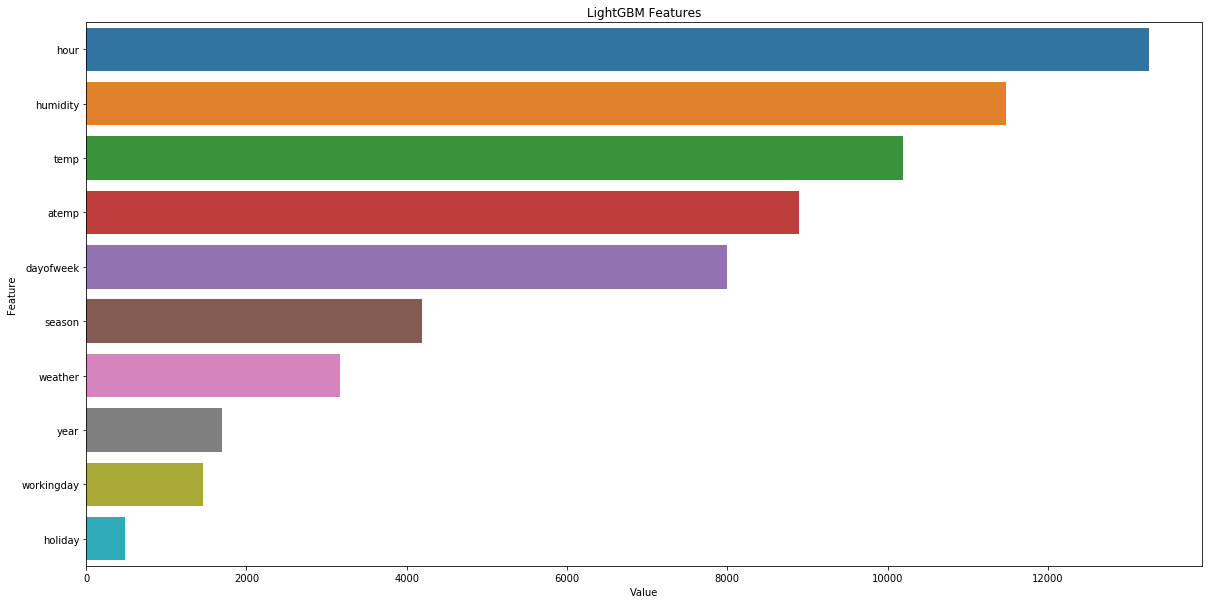

In [16]:
#feature의 importance, Train시에 feature selection에 사용가능 
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.show()